In [2]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using Pytorch version', torch.__version__)

Using Pytorch version 1.12.0+cpu


# importing library

In [3]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [3]:
os.path.isdir(os.path.join(root_dir,source_dirs[1]))

False

In [4]:
images=[]
for x in os.listdir(os.path.join(root_dir, class_names[0])):
    if x.lower().endswith('png'):
        images.append(x)
print(images)

['Normal-1.png', 'Normal-10.png', 'Normal-100.png', 'Normal-1000.png', 'Normal-10000.png', 'Normal-10001.png', 'Normal-10002.png', 'Normal-10003.png', 'Normal-10004.png', 'Normal-10005.png', 'Normal-10006.png', 'Normal-10007.png', 'Normal-10008.png', 'Normal-10009.png', 'Normal-1001.png', 'Normal-10010.png', 'Normal-10011.png', 'Normal-10012.png', 'Normal-10013.png', 'Normal-10014.png', 'Normal-10015.png', 'Normal-10016.png', 'Normal-10017.png', 'Normal-10018.png', 'Normal-10019.png', 'Normal-1002.png', 'Normal-10020.png', 'Normal-10021.png', 'Normal-10022.png', 'Normal-10023.png', 'Normal-10024.png', 'Normal-10025.png', 'Normal-10026.png', 'Normal-10027.png', 'Normal-10028.png', 'Normal-10029.png', 'Normal-1003.png', 'Normal-10030.png', 'Normal-10031.png', 'Normal-10032.png', 'Normal-10033.png', 'Normal-10034.png', 'Normal-10035.png', 'Normal-10036.png', 'Normal-10037.png', 'Normal-10038.png', 'Normal-10039.png', 'Normal-1004.png', 'Normal-10040.png', 'Normal-10041.png', 'Normal-10042

# Creating Custom Dataset

In [29]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}#use dictionary to keep track of images in different classes
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')#because resnet18 need 3 channels input, so we convert it to RGB
        return self.transform(image), self.class_names.index(class_name)#example and label
    

In [30]:
self.image_dirs

NameError: name 'self' is not defined

# Image transformation

In [31]:
train_transform = torchvision.transforms.Compose([   #use compose to get together all steps
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),  #so that it can used in computation by pytorch
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], #use pretrained model officially use these numbers
                                    std=[0.229, 0.224, 0.225])
])

In [32]:
#test and valid don't need augmantation
test_transform = torchvision.transforms.Compose([   #use compose to get together all steps
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),  #so that it can used in computation by pytorch
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], #use pretrained model officially use these numbers
                                    std=[0.229, 0.224, 0.225])
])

# Prepare data loader

In [33]:
train_dirs = {
    'normal':'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}


In [34]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10042 normal examples
Found 1195 viral examples
Found 3466 covid examples


In [35]:
test_dirs = {
    'normal':'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

In [36]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [37]:
batch_size = 6#data loader 用來準備梯度下降用的batch資料,每個batch資料是不同的組合

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2451
Number of test batches 15


# Data Visualization

In [38]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    #going to display 6 image(1 batch at a time)
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))#change first to the last
        #convert picture value to original value that were before normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean #逆向復原
        image = np.clip(image, 0., 1.) #將value限制在0與1
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}') 
        #tensor-->numpy
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [39]:
len(dl_train)

2451

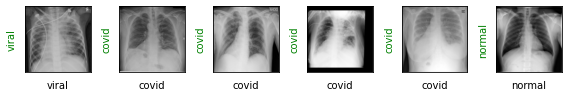

In [42]:
images, labels = next(iter(dl_train)) #used for working with iterables, which calls the __iter__() and __next__() method
show_images(images, labels, labels)

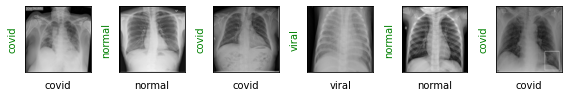

In [43]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [44]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

C:\Users\M100\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\M100\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\M100/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
# last layer output features = 1000 --> output feature = 3
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss() #because we are classification
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [57]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test)) #get dataset
    outputs = resnet18(images)
    _, preds =  torch.max(outputs, 1) # 0 is number of examples, 1 is value
    show_images(images, labels, preds)

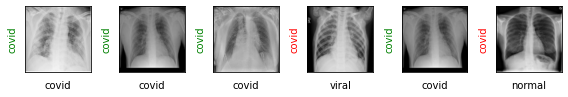

In [58]:
show_preds() #our model not trained right now

# Training the model

In [59]:
# epochs 總共要用全部的訓練樣本重複跑幾回合
def train(epochs):
    print('Starting training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()#set model to training phase
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad() #set gradient to zero
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step() #to complete gradient step
            train_loss += loss.item() #loss itself is tensor so add loss.item
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0 #accuracy
                val_loss = 0 #validation loss
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images) #images is from test dataset
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy()) #preds == labels --> 1
                                                          #preds != labels --> 0
                val_loss /= (val_step + 1)   # because we have 90 examples, 90/6=15, so we have 15 steps
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc: 4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition satisfied..')
                    return
                
            train_loss /= (train_step + 1)
            
            print(f'Training Loss: {train_loss:.4f}')
        print('Training complete..')
                    

Starting training...
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.2084, Acc:  0.344444


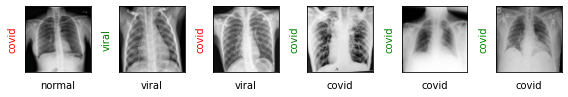

Training Loss: 1.2406
Training Loss: 1.2407
Training Loss: 0.7914
Training Loss: 0.4836
Training Loss: 0.3336
Training Loss: 0.2184
Training Loss: 0.1884
Training Loss: 0.1269
Training Loss: 0.1278
Training Loss: 0.1333
Training Loss: 0.0796
Training Loss: 0.0765
Training Loss: 0.0632
Training Loss: 0.0544
Training Loss: 0.0611
Training Loss: 0.0528
Training Loss: 0.0639
Training Loss: 0.0458
Training Loss: 0.0333
Training Loss: 0.0528
Evaluating at step 20
Val loss: 0.7999, Acc:  0.644444


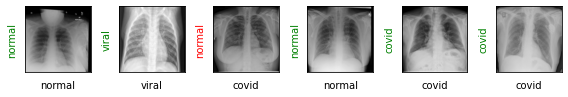

Training Loss: 0.0325
Training Loss: 0.0352
Training Loss: 0.0302
Training Loss: 0.0363
Training Loss: 0.0432
Training Loss: 0.0366
Training Loss: 0.0363
Training Loss: 0.0286
Training Loss: 0.0192
Training Loss: 0.0169
Training Loss: 0.0167
Training Loss: 0.0244
Training Loss: 0.0287
Training Loss: 0.0159
Training Loss: 0.0275
Training Loss: 0.0281
Training Loss: 0.0176
Training Loss: 0.0120
Training Loss: 0.0196
Training Loss: 0.0248
Evaluating at step 40
Val loss: 0.5724, Acc:  0.788889


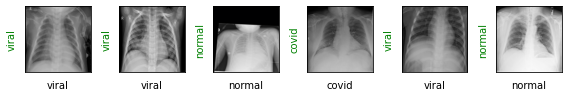

Training Loss: 0.0123
Training Loss: 0.0091
Training Loss: 0.0186
Training Loss: 0.0132
Training Loss: 0.0061
Training Loss: 0.0215
Training Loss: 0.0120
Training Loss: 0.0158
Training Loss: 0.0200
Training Loss: 0.0118
Training Loss: 0.0095
Training Loss: 0.0138
Training Loss: 0.0123
Training Loss: 0.0086
Training Loss: 0.0069
Training Loss: 0.0086
Training Loss: 0.0109
Training Loss: 0.0071
Training Loss: 0.0083
Training Loss: 0.0075
Evaluating at step 60
Val loss: 0.4568, Acc:  0.877778


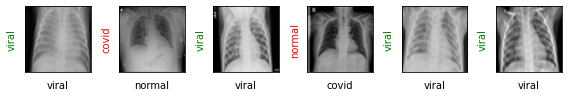

Training Loss: 0.0038
Training Loss: 0.0097
Training Loss: 0.0074
Training Loss: 0.0081
Training Loss: 0.0053
Training Loss: 0.0044
Training Loss: 0.0058
Training Loss: 0.0073
Training Loss: 0.0076
Training Loss: 0.0073
Training Loss: 0.0024
Training Loss: 0.0048
Training Loss: 0.0027
Training Loss: 0.0034
Training Loss: 0.0119
Training Loss: 0.0024
Training Loss: 0.0104
Training Loss: 0.0082
Training Loss: 0.0055
Training Loss: 0.0051
Evaluating at step 80
Val loss: 0.3865, Acc:  0.844444


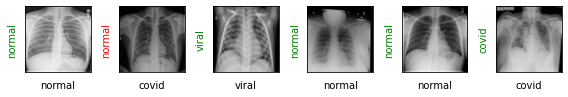

Training Loss: 0.0045
Training Loss: 0.0041
Training Loss: 0.0089
Training Loss: 0.0044
Training Loss: 0.0050
Training Loss: 0.0072
Training Loss: 0.0028
Training Loss: 0.0071
Training Loss: 0.0063
Training Loss: 0.0032
Training Loss: 0.0074
Training Loss: 0.0032
Training Loss: 0.0084
Training Loss: 0.0018
Training Loss: 0.0054
Training Loss: 0.0061
Training Loss: 0.0040
Training Loss: 0.0052
Training Loss: 0.0020
Training Loss: 0.0049
Evaluating at step 100
Val loss: 0.3699, Acc:  0.900000


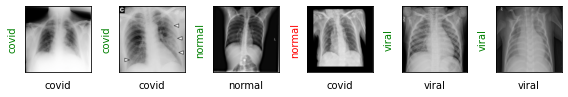

Training Loss: 0.0030
Training Loss: 0.0027
Training Loss: 0.0048
Training Loss: 0.0027
Training Loss: 0.0024
Training Loss: 0.0023
Training Loss: 0.0072
Training Loss: 0.0047
Training Loss: 0.0033
Training Loss: 0.0042
Training Loss: 0.0023
Training Loss: 0.0028
Training Loss: 0.0023
Training Loss: 0.0018
Training Loss: 0.0010
Training Loss: 0.0046
Training Loss: 0.0012
Training Loss: 0.0018
Training Loss: 0.0022
Training Loss: 0.0060
Evaluating at step 120
Val loss: 0.3370, Acc:  0.833333


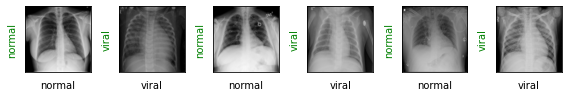

Training Loss: 0.0014
Training Loss: 0.0028
Training Loss: 0.0035
Training Loss: 0.0016
Training Loss: 0.0017
Training Loss: 0.0027
Training Loss: 0.0021
Training Loss: 0.0055
Training Loss: 0.0031
Training Loss: 0.0030
Training Loss: 0.0034
Training Loss: 0.0026
Training Loss: 0.0073
Training Loss: 0.0056
Training Loss: 0.0040
Training Loss: 0.0035
Training Loss: 0.0031
Training Loss: 0.0006
Training Loss: 0.0015
Training Loss: 0.0013
Evaluating at step 140
Val loss: 0.2985, Acc:  0.900000


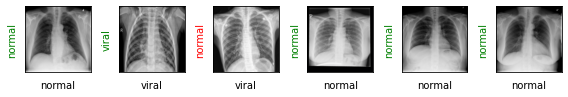

Training Loss: 0.0040
Training Loss: 0.0069
Training Loss: 0.0045
Training Loss: 0.0014
Training Loss: 0.0028
Training Loss: 0.0027
Training Loss: 0.0018
Training Loss: 0.0012
Training Loss: 0.0030
Training Loss: 0.0049
Training Loss: 0.0049
Training Loss: 0.0023
Training Loss: 0.0023
Training Loss: 0.0033
Training Loss: 0.0030
Training Loss: 0.0015
Training Loss: 0.0027
Training Loss: 0.0012
Training Loss: 0.0052
Training Loss: 0.0022
Evaluating at step 160
Val loss: 0.2356, Acc:  0.911111


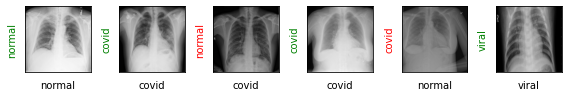

Training Loss: 0.0023
Training Loss: 0.0049
Training Loss: 0.0070
Training Loss: 0.0025
Training Loss: 0.0011
Training Loss: 0.0031
Training Loss: 0.0048
Training Loss: 0.0033
Training Loss: 0.0013
Training Loss: 0.0051
Training Loss: 0.0026
Training Loss: 0.0006
Training Loss: 0.0023
Training Loss: 0.0035
Training Loss: 0.0006
Training Loss: 0.0038
Training Loss: 0.0028
Training Loss: 0.0032
Training Loss: 0.0020
Training Loss: 0.0026
Evaluating at step 180
Val loss: 0.2850, Acc:  0.911111


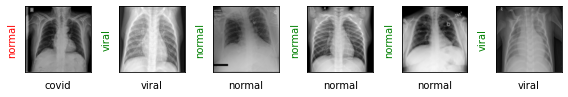

Training Loss: 0.0005
Training Loss: 0.0008
Training Loss: 0.0011
Training Loss: 0.0010
Training Loss: 0.0044
Training Loss: 0.0018
Training Loss: 0.0025
Training Loss: 0.0035
Training Loss: 0.0009
Training Loss: 0.0016
Training Loss: 0.0031
Training Loss: 0.0011
Training Loss: 0.0027
Training Loss: 0.0005
Training Loss: 0.0029
Training Loss: 0.0018
Training Loss: 0.0018
Training Loss: 0.0036
Training Loss: 0.0011
Training Loss: 0.0059
Evaluating at step 200
Val loss: 0.2532, Acc:  0.922222


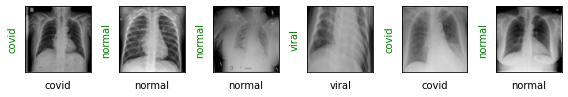

Training Loss: 0.0061
Training Loss: 0.0015
Training Loss: 0.0056
Training Loss: 0.0025
Training Loss: 0.0025
Training Loss: 0.0005
Training Loss: 0.0007
Training Loss: 0.0003
Training Loss: 0.0027
Training Loss: 0.0024
Training Loss: 0.0015
Training Loss: 0.0014
Training Loss: 0.0031
Training Loss: 0.0010
Training Loss: 0.0018
Training Loss: 0.0042
Training Loss: 0.0007
Training Loss: 0.0004
Training Loss: 0.0012
Training Loss: 0.0041
Evaluating at step 220
Val loss: 0.2758, Acc:  0.922222


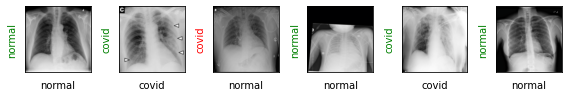

Training Loss: 0.0007
Training Loss: 0.0005
Training Loss: 0.0012
Training Loss: 0.0016
Training Loss: 0.0015
Training Loss: 0.0013
Training Loss: 0.0011
Training Loss: 0.0011
Training Loss: 0.0009
Training Loss: 0.0017
Training Loss: 0.0004
Training Loss: 0.0010
Training Loss: 0.0009
Training Loss: 0.0007
Training Loss: 0.0019
Training Loss: 0.0039
Training Loss: 0.0014
Training Loss: 0.0022
Training Loss: 0.0020
Training Loss: 0.0012
Evaluating at step 240
Val loss: 0.1850, Acc:  0.933333


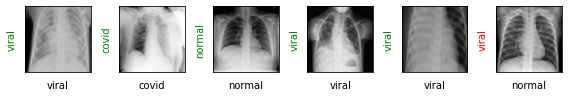

Training Loss: 0.0012
Training Loss: 0.0007
Training Loss: 0.0009
Training Loss: 0.0010
Training Loss: 0.0022
Training Loss: 0.0002
Training Loss: 0.0013
Training Loss: 0.0032
Training Loss: 0.0012
Training Loss: 0.0004
Training Loss: 0.0009
Training Loss: 0.0010
Training Loss: 0.0057
Training Loss: 0.0003
Training Loss: 0.0010
Training Loss: 0.0032
Training Loss: 0.0002
Training Loss: 0.0024
Training Loss: 0.0016
Training Loss: 0.0010
Evaluating at step 260
Val loss: 0.2548, Acc:  0.888889


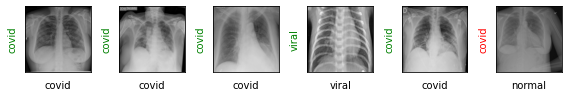

Training Loss: 0.0009
Training Loss: 0.0005
Training Loss: 0.0003
Training Loss: 0.0030
Training Loss: 0.0029
Training Loss: 0.0004
Training Loss: 0.0006
Training Loss: 0.0016
Training Loss: 0.0014
Training Loss: 0.0001
Training Loss: 0.0004
Training Loss: 0.0023
Training Loss: 0.0004
Training Loss: 0.0004
Training Loss: 0.0015
Training Loss: 0.0004
Training Loss: 0.0010
Training Loss: 0.0018
Training Loss: 0.0003
Training Loss: 0.0008
Evaluating at step 280
Val loss: 0.1663, Acc:  0.922222


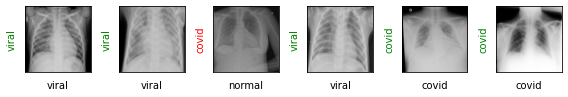

Training Loss: 0.0008
Training Loss: 0.0003
Training Loss: 0.0041
Training Loss: 0.0008
Training Loss: 0.0003
Training Loss: 0.0041
Training Loss: 0.0003
Training Loss: 0.0035
Training Loss: 0.0013
Training Loss: 0.0003
Training Loss: 0.0013
Training Loss: 0.0016
Training Loss: 0.0002
Training Loss: 0.0004
Training Loss: 0.0013
Training Loss: 0.0002
Training Loss: 0.0006
Training Loss: 0.0014
Training Loss: 0.0004
Training Loss: 0.0007
Evaluating at step 300
Val loss: 0.1944, Acc:  0.922222


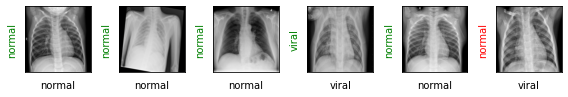

Training Loss: 0.0014
Training Loss: 0.0011
Training Loss: 0.0009
Training Loss: 0.0012
Training Loss: 0.0001
Training Loss: 0.0007
Training Loss: 0.0012
Training Loss: 0.0007
Training Loss: 0.0007
Training Loss: 0.0011
Training Loss: 0.0016
Training Loss: 0.0001
Training Loss: 0.0003
Training Loss: 0.0011
Training Loss: 0.0010
Training Loss: 0.0002
Training Loss: 0.0007
Training Loss: 0.0006
Training Loss: 0.0021
Training Loss: 0.0010
Evaluating at step 320
Val loss: 0.1764, Acc:  0.933333


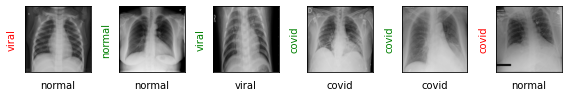

Training Loss: 0.0004
Training Loss: 0.0001
Training Loss: 0.0011
Training Loss: 0.0001
Training Loss: 0.0010
Training Loss: 0.0010
Training Loss: 0.0005
Training Loss: 0.0018
Training Loss: 0.0003
Training Loss: 0.0003
Training Loss: 0.0002
Training Loss: 0.0005
Training Loss: 0.0005
Training Loss: 0.0003
Training Loss: 0.0002
Training Loss: 0.0015
Training Loss: 0.0013
Training Loss: 0.0008
Training Loss: 0.0018
Training Loss: 0.0007
Evaluating at step 340
Val loss: 0.2171, Acc:  0.922222


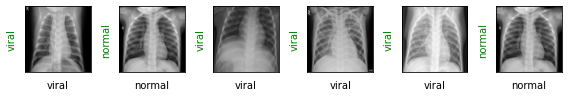

Training Loss: 0.0004
Training Loss: 0.0010
Training Loss: 0.0005
Training Loss: 0.0006
Training Loss: 0.0007
Training Loss: 0.0012
Training Loss: 0.0004
Training Loss: 0.0021
Training Loss: 0.0005
Training Loss: 0.0004
Training Loss: 0.0025
Training Loss: 0.0002
Training Loss: 0.0020
Training Loss: 0.0004
Training Loss: 0.0006
Training Loss: 0.0007
Training Loss: 0.0003
Training Loss: 0.0003
Training Loss: 0.0015
Training Loss: 0.0022
Evaluating at step 360
Val loss: 0.4128, Acc:  0.855556


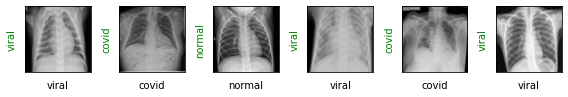

Training Loss: 0.0005
Training Loss: 0.0008
Training Loss: 0.0005
Training Loss: 0.0007
Training Loss: 0.0006
Training Loss: 0.0005
Training Loss: 0.0013
Training Loss: 0.0004
Training Loss: 0.0014
Training Loss: 0.0008
Training Loss: 0.0010
Training Loss: 0.0007
Training Loss: 0.0005
Training Loss: 0.0007
Training Loss: 0.0031
Training Loss: 0.0006
Training Loss: 0.0005
Training Loss: 0.0005
Training Loss: 0.0002
Training Loss: 0.0004
Evaluating at step 380
Val loss: 0.3618, Acc:  0.877778


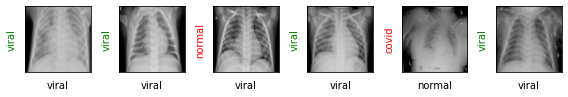

Training Loss: 0.0004
Training Loss: 0.0002
Training Loss: 0.0008
Training Loss: 0.0003
Training Loss: 0.0006
Training Loss: 0.0009
Training Loss: 0.0012
Training Loss: 0.0009
Training Loss: 0.0005
Training Loss: 0.0001
Training Loss: 0.0009
Training Loss: 0.0000
Training Loss: 0.0012
Training Loss: 0.0007
Training Loss: 0.0008
Training Loss: 0.0033
Training Loss: 0.0014
Training Loss: 0.0002
Training Loss: 0.0003
Training Loss: 0.0004
Evaluating at step 400
Val loss: 0.3600, Acc:  0.855556


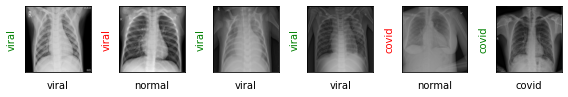

Training Loss: 0.0001
Training Loss: 0.0004
Training Loss: 0.0027
Training Loss: 0.0006
Training Loss: 0.0002
Training Loss: 0.0007
Training Loss: 0.0013
Training Loss: 0.0001
Training Loss: 0.0002
Training Loss: 0.0001
Training Loss: 0.0005
Training Loss: 0.0024
Training Loss: 0.0001
Training Loss: 0.0005
Training Loss: 0.0000
Training Loss: 0.0010
Training Loss: 0.0013
Training Loss: 0.0002
Training Loss: 0.0003
Training Loss: 0.0003
Evaluating at step 420
Val loss: 0.3437, Acc:  0.855556


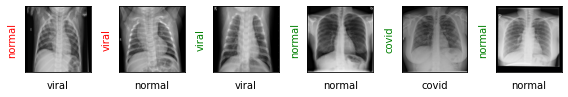

Training Loss: 0.0007
Training Loss: 0.0012
Training Loss: 0.0002
Training Loss: 0.0026
Training Loss: 0.0003
Training Loss: 0.0003
Training Loss: 0.0019
Training Loss: 0.0001
Training Loss: 0.0005
Training Loss: 0.0004
Training Loss: 0.0008
Training Loss: 0.0002
Training Loss: 0.0020
Training Loss: 0.0017
Training Loss: 0.0014
Training Loss: 0.0007
Training Loss: 0.0003
Training Loss: 0.0012
Training Loss: 0.0004
Training Loss: 0.0002
Evaluating at step 440
Val loss: 0.1874, Acc:  0.922222


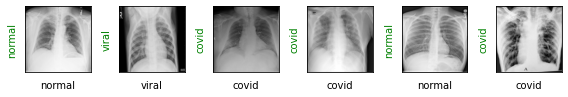

Training Loss: 0.0002
Training Loss: 0.0002
Training Loss: 0.0013
Training Loss: 0.0001
Training Loss: 0.0006
Training Loss: 0.0002
Training Loss: 0.0003
Training Loss: 0.0003
Training Loss: 0.0003
Training Loss: 0.0002
Training Loss: 0.0016
Training Loss: 0.0002
Training Loss: 0.0009
Training Loss: 0.0003
Training Loss: 0.0001
Training Loss: 0.0005
Training Loss: 0.0010
Training Loss: 0.0003
Training Loss: 0.0022
Training Loss: 0.0006
Evaluating at step 460
Val loss: 0.2068, Acc:  0.933333


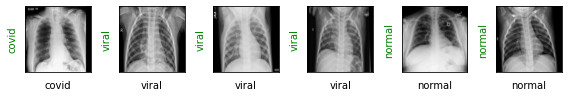

Training Loss: 0.0005
Training Loss: 0.0017
Training Loss: 0.0003
Training Loss: 0.0006
Training Loss: 0.0006
Training Loss: 0.0004
Training Loss: 0.0008
Training Loss: 0.0002
Training Loss: 0.0002
Training Loss: 0.0005
Training Loss: 0.0009
Training Loss: 0.0003
Training Loss: 0.0001
Training Loss: 0.0006
Training Loss: 0.0001
Training Loss: 0.0010
Training Loss: 0.0003
Training Loss: 0.0003
Training Loss: 0.0001
Training Loss: 0.0007
Evaluating at step 480
Val loss: 0.1310, Acc:  0.955556


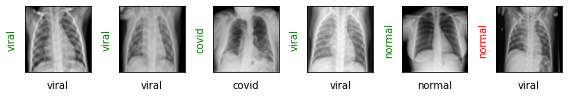

Performance condition satisfied..
CPU times: total: 43min 2s
Wall time: 5min 27s


In [60]:
%%time

train(epochs=1)

# Final Results

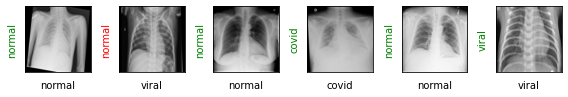

In [61]:
show_preds()